In [155]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model

In [156]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [161]:
def train_embedding():
    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    curve_list = []
    model_acc_list = []
    emb_dim_list = [100, 200, 300, 400, 500]
    for emb_dim in emb_dim_list:
        model = BagOfWords(len(id2token), emb_dim)

        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        val_acc_list = []
        for epoch in tqdm.trange(num_epochs):
            for i, (data, lengths, labels) in enumerate(train_loader):
                model.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                optimizer.zero_grad()
                outputs = model(data_batch, length_batch)
                loss = criterion(outputs, label_batch)
                loss.backward()
                val_acc = test_model(val_loader, model)
                optimizer.step()

            val_acc_list.append(val_acc)
            if learning_rate_decay == True:
                scheduler.step(val_acc)
        curve_list.append(val_acc_list)
        model_acc_list.append(test_model(val_loader, model))
        print('finish embedding dimension %s, val_acc: %s' %(emb_dim, test_model(val_loader, model)))
    return curve_list, model_acc_list

In [157]:
ngram_dct = pk.load(open("ngram_dct.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))


In [160]:
#unigram

In [122]:
# create all train tokens 
import itertools
train_features = ngram_dct['train_1']
val_features = ngram_dct['val_1']
test_features = ngram_dct['test_1']


max_vocab_size = 20000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)

MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

In [147]:
val_curve_adam_unigram_embedsize, val_acc_adam_embedsize = train_embedding()








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [02:38<23:45, 158.34s/it]






 20%|██        | 2/10 [05:11<20:46, 155.75s/it]






 30%|███       | 3/10 [07:46<18:07, 155.34s/it]






 40%|████      | 4/10 [10:29<15:43, 157.26s/it]






 50%|█████     | 5/10 [12:54<12:54, 154.81s/it]






 60%|██████    | 6/10 [14:47<09:51, 147.96s/it]






 70%|███████   | 7/10 [16:41<07:09, 143.10s/it]






 80%|████████  | 8/10 [18:35<04:38, 139.40s/it]






 90%|█████████ | 9/10 [20:28<02:16, 136.53s/it]






100%|██████████| 10/10 [22:32<00:00, 135.23s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 100, val_acc: 83.02









 10%|█         | 1/10 [02:21<21:17, 141.99s/it]






 20%|██        | 2/10 [04:46<19:05, 143.18s/it]






 30%|███       | 3/10 [07:07<16:38, 142.62s/it]






 40%|████      | 4/10 [09:37<14:26, 144.43s/it]






 50%|█████     | 5/10 [12:24<12:24, 149.00s/it]






 60%|██████    | 6/10 [15:08<10:05, 151.43s/it]






 70%|███████   | 7/10 [17:50<07:38, 153.00s/it]






 80%|████████  | 8/10 [20:34<05:08, 154.27s/it]






 90%|█████████ | 9/10 [23:17<02:35, 155.23s/it]






100%|██████████| 10/10 [26:00<00:00, 156.00s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 200, val_acc: 82.8









 10%|█         | 1/10 [04:16<38:30, 256.70s/it]






 20%|██        | 2/10 [08:37<34:30, 258.86s/it]






 30%|███       | 3/10 [12:57<30:13, 259.02s/it]






 40%|████      | 4/10 [17:13<25:50, 258.38s/it]






 50%|█████     | 5/10 [21:36<21:36, 259.22s/it]






 60%|██████    | 6/10 [25:48<17:12, 258.15s/it]






 70%|███████   | 7/10 [30:01<12:52, 257.37s/it]






 80%|████████  | 8/10 [34:22<08:35, 257.81s/it]






 90%|█████████ | 9/10 [39:05<04:20, 260.58s/it]






100%|██████████| 10/10 [44:10<00:00, 265.09s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 300, val_acc: 82.22









 10%|█         | 1/10 [06:20<57:08, 380.94s/it]






 20%|██        | 2/10 [12:42<50:48, 381.07s/it]






 30%|███       | 3/10 [19:04<44:31, 381.60s/it]






 40%|████      | 4/10 [25:27<38:11, 381.85s/it]






 50%|█████     | 5/10 [31:49<31:49, 381.92s/it]






 60%|██████    | 6/10 [38:12<25:28, 382.12s/it]






 70%|███████   | 7/10 [44:39<19:08, 382.84s/it]






 80%|████████  | 8/10 [51:07<12:46, 383.40s/it]






 90%|█████████ | 9/10 [57:34<06:23, 383.87s/it]






100%|██████████| 10/10 [1:04:02<00:00, 384.26s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 400, val_acc: 82.48









 10%|█         | 1/10 [07:16<1:05:31, 436.84s/it]






 20%|██        | 2/10 [14:32<58:11, 436.48s/it]  






 30%|███       | 3/10 [21:46<50:48, 435.44s/it]






 40%|████      | 4/10 [28:46<43:09, 431.54s/it]






 50%|█████     | 5/10 [34:58<34:58, 419.71s/it]






 60%|██████    | 6/10 [41:11<27:27, 411.85s/it]






 70%|███████   | 7/10 [47:24<20:18, 406.29s/it]






 80%|████████  | 8/10 [53:36<13:24, 402.02s/it]






 90%|█████████ | 9/10 [59:46<06:38, 398.54s/it]






100%|██████████| 10/10 [1:05:57<00:00, 395.75s/it]








finish embedding dimension 500, val_acc: 82.76


Text(0.5,1,'spacy tokenization, unigram, adam optimization (lr=0.01), vocab_size = 20000')

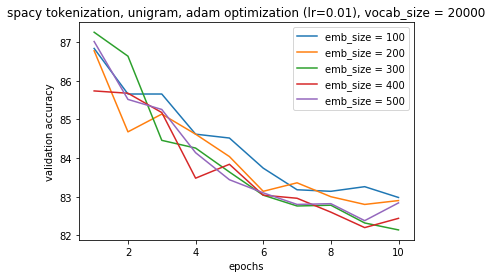

In [154]:
emb_dim_list = [100, 200, 300, 400, 500]
for i in range(len(val_curve_adam_unigram_embedsize)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_unigram_embedsize[i], label = 'emb_size = %s' %emb_dim_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, unigram, adam optimization (lr=0.01), vocab_size = %s' %max_vocab_size)

## bigram

In [162]:
# create all train tokens 
import itertools
train_features = ngram_dct['train_2']
val_features = ngram_dct['val_2']
test_features = ngram_dct['test_2']


max_vocab_size = 20000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)

MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

In [163]:
val_curve_adam_bigram_embedsize, val_acc_adam_bigram_embedsize = train_embedding()








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [02:17<20:35, 137.27s/it]






 20%|██        | 2/10 [04:33<18:13, 136.70s/it]






 30%|███       | 3/10 [06:50<15:58, 136.96s/it]






 40%|████      | 4/10 [09:06<13:39, 136.59s/it]






 50%|█████     | 5/10 [11:24<11:24, 136.94s/it]






 60%|██████    | 6/10 [13:41<09:07, 136.87s/it]






 70%|███████   | 7/10 [15:55<06:49, 136.53s/it]






 80%|████████  | 8/10 [18:10<04:32, 136.34s/it]






 90%|█████████ | 9/10 [20:28<02:16, 136.54s/it]






100%|██████████| 10/10 [22:42<00:00, 136.25s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 100, val_acc: 82.8









 10%|█         | 1/10 [03:24<30:40, 204.51s/it]






 20%|██        | 2/10 [06:48<27:13, 204.21s/it]






 30%|███       | 3/10 [10:12<23:48, 204.14s/it]






 40%|████      | 4/10 [13:38<20:27, 204.65s/it]






 50%|█████     | 5/10 [17:18<17:18, 207.61s/it]






 60%|██████    | 6/10 [20:51<13:54, 208.57s/it]






 70%|███████   | 7/10 [24:17<10:24, 208.26s/it]






 80%|████████  | 8/10 [27:49<06:57, 208.63s/it]






 90%|█████████ | 9/10 [31:23<03:29, 209.29s/it]






100%|██████████| 10/10 [34:57<00:00, 209.75s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 200, val_acc: 82.52









 10%|█         | 1/10 [03:20<30:06, 200.67s/it]






 20%|██        | 2/10 [06:41<26:47, 200.99s/it]






 30%|███       | 3/10 [10:01<23:23, 200.49s/it]






 40%|████      | 4/10 [13:23<20:04, 200.81s/it]






 50%|█████     | 5/10 [16:44<16:44, 200.83s/it]






 60%|██████    | 6/10 [20:07<13:25, 201.29s/it]






 70%|███████   | 7/10 [23:28<10:03, 201.17s/it]






 80%|████████  | 8/10 [26:41<06:40, 200.22s/it]






 90%|█████████ | 9/10 [30:05<03:20, 200.65s/it]






100%|██████████| 10/10 [33:25<00:00, 200.52s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 300, val_acc: 82.82









 10%|█         | 1/10 [05:14<47:14, 314.94s/it]






 20%|██        | 2/10 [10:32<42:08, 316.06s/it]






 30%|███       | 3/10 [15:39<36:31, 313.10s/it]






 40%|████      | 4/10 [1:11:13<1:46:49, 1068.27s/it]






 50%|█████     | 5/10 [1:15:57<1:15:57, 911.50s/it] 






 60%|██████    | 6/10 [1:21:00<54:00, 810.04s/it]  






 70%|███████   | 7/10 [1:26:00<36:51, 737.20s/it]






 80%|████████  | 8/10 [1:31:02<22:45, 682.86s/it]






 90%|█████████ | 9/10 [1:36:05<10:40, 640.58s/it]






100%|██████████| 10/10 [1:42:38<00:00, 615.84s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 400, val_acc: 82.2









 10%|█         | 1/10 [06:26<57:59, 386.64s/it]






 20%|██        | 2/10 [44:50<2:59:22, 1345.35s/it]






 30%|███       | 3/10 [51:22<1:59:53, 1027.61s/it]






 40%|████      | 4/10 [57:53<1:26:50, 868.38s/it] 






 50%|█████     | 5/10 [1:04:24<1:04:24, 772.87s/it]






 60%|██████    | 6/10 [1:10:55<47:16, 709.17s/it]  






 70%|███████   | 7/10 [1:17:25<33:10, 663.61s/it]






 80%|████████  | 8/10 [1:23:55<20:58, 629.47s/it]






 90%|█████████ | 9/10 [1:30:31<10:03, 603.49s/it]






100%|██████████| 10/10 [1:37:06<00:00, 582.68s/it]








finish embedding dimension 500, val_acc: 82.42


Text(0.5,1,'spacy tokenization, bigram, adam optimization (lr=0.01), vocab_size = 20000')

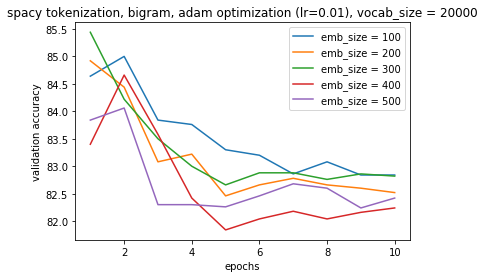

In [165]:
emb_dim_list = [100, 200, 300, 400, 500]
for i in range(len(val_curve_adam_bigram_embedsize)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_bigram_embedsize[i], label = 'emb_size = %s' %emb_dim_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, bigram, adam optimization (lr=0.01), vocab_size = %s' %max_vocab_size)

## trigram

In [166]:
# create all train tokens 
import itertools
train_features = ngram_dct['train_3']
val_features = ngram_dct['val_3']
test_features = ngram_dct['test_3']


max_vocab_size = 20000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)

MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

In [167]:
val_curve_adam_trigram_embedsize, val_acc_adam_trigram_embedsize = train_embedding()








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [02:13<19:57, 133.11s/it]






 20%|██        | 2/10 [04:21<17:26, 130.78s/it]






 30%|███       | 3/10 [06:30<15:10, 130.03s/it]






 40%|████      | 4/10 [08:38<12:57, 129.54s/it]






 50%|█████     | 5/10 [10:46<10:46, 129.35s/it]






 60%|██████    | 6/10 [12:55<08:37, 129.26s/it]






 70%|███████   | 7/10 [15:05<06:28, 129.42s/it]






 80%|████████  | 8/10 [17:15<04:18, 129.50s/it]






 90%|█████████ | 9/10 [19:26<02:09, 129.60s/it]






100%|██████████| 10/10 [21:36<00:00, 129.63s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 100, val_acc: 78.08









 10%|█         | 1/10 [03:21<30:17, 201.93s/it]






 20%|██        | 2/10 [06:47<27:10, 203.82s/it]






 30%|███       | 3/10 [26:27<1:01:44, 529.28s/it]






 40%|████      | 4/10 [30:00<45:00, 450.16s/it]  






 50%|█████     | 5/10 [33:35<33:35, 403.18s/it]






 60%|██████    | 6/10 [37:09<24:46, 371.58s/it]






 70%|███████   | 7/10 [40:41<17:26, 348.81s/it]






 80%|████████  | 8/10 [44:13<11:03, 331.73s/it]






 90%|█████████ | 9/10 [47:52<05:19, 319.14s/it]






100%|██████████| 10/10 [51:31<00:00, 309.12s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 200, val_acc: 78.0









 10%|█         | 1/10 [04:17<38:35, 257.23s/it]






 20%|██        | 2/10 [09:05<36:21, 272.71s/it]






 30%|███       | 3/10 [13:58<32:36, 279.47s/it]






 40%|████      | 4/10 [18:59<28:29, 284.97s/it]






 50%|█████     | 5/10 [23:59<23:59, 287.89s/it]






 60%|██████    | 6/10 [29:03<19:22, 290.54s/it]






 70%|███████   | 7/10 [34:04<14:36, 292.09s/it]






 80%|████████  | 8/10 [39:06<09:46, 293.29s/it]






 90%|█████████ | 9/10 [44:18<04:55, 295.34s/it]






100%|██████████| 10/10 [49:24<00:00, 296.43s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 300, val_acc: 78.44









 10%|█         | 1/10 [12:02<1:48:18, 722.10s/it]






 20%|██        | 2/10 [17:35<1:10:21, 527.66s/it]






 30%|███       | 3/10 [23:12<54:08, 464.02s/it]  






 40%|████      | 4/10 [28:49<43:14, 432.38s/it]






 50%|█████     | 5/10 [34:27<34:27, 413.57s/it]






 60%|██████    | 6/10 [40:05<26:43, 400.91s/it]






 70%|███████   | 7/10 [45:43<19:35, 391.87s/it]






 80%|████████  | 8/10 [50:46<12:41, 380.76s/it]






 90%|█████████ | 9/10 [55:39<06:11, 371.02s/it]






100%|██████████| 10/10 [1:00:32<00:00, 363.26s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 400, val_acc: 77.9









 10%|█         | 1/10 [05:49<52:28, 349.78s/it]






 20%|██        | 2/10 [11:38<46:35, 349.43s/it]






 30%|███       | 3/10 [17:28<40:46, 349.46s/it]






 40%|████      | 4/10 [23:17<34:56, 349.38s/it]






 50%|█████     | 5/10 [29:06<29:06, 349.36s/it]






 60%|██████    | 6/10 [34:58<23:18, 349.74s/it]






 70%|███████   | 7/10 [1:17:04<33:01, 660.59s/it]






 80%|████████  | 8/10 [1:23:04<20:46, 623.04s/it]






 90%|█████████ | 9/10 [1:28:55<09:52, 592.86s/it]






100%|██████████| 10/10 [1:34:47<00:00, 568.80s/it]








finish embedding dimension 500, val_acc: 77.9


Text(0.5,1,'spacy tokenization, trigram, adam optimization (lr=0.01), vocab_size = 20000')

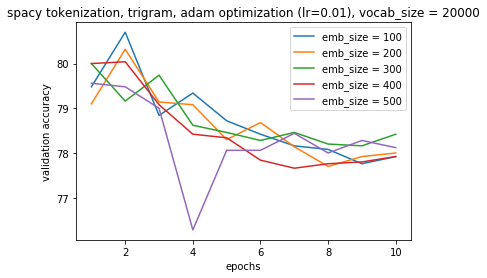

In [168]:
emb_dim_list = [100, 200, 300, 400, 500]
for i in range(len(val_curve_adam_trigram_embedsize)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_trigram_embedsize[i], label = 'emb_size = %s' %emb_dim_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, trigram, adam optimization (lr=0.01), vocab_size = %s' %max_vocab_size)

## 4gram

In [169]:
# create all train tokens 
import itertools
train_features = ngram_dct['train_4']
val_features = ngram_dct['val_4']
test_features = ngram_dct['test_4']


max_vocab_size = 20000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)

MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

In [170]:
val_curve_adam_4gram_embedsize, val_acc_adam_4gram_embedsize = train_embedding()








  0%|          | 0/10 [00:00<?, ?it/s]






 10%|█         | 1/10 [02:06<18:56, 126.25s/it]






 20%|██        | 2/10 [04:10<16:42, 125.29s/it]






 30%|███       | 3/10 [06:15<14:36, 125.20s/it]






 40%|████      | 4/10 [08:20<12:30, 125.15s/it]






 50%|█████     | 5/10 [10:25<10:25, 125.08s/it]






 60%|██████    | 6/10 [12:30<08:20, 125.07s/it]






 70%|███████   | 7/10 [14:38<06:16, 125.49s/it]






 80%|████████  | 8/10 [16:55<04:13, 126.91s/it]






 90%|█████████ | 9/10 [19:06<02:07, 127.39s/it]






100%|██████████| 10/10 [21:16<00:00, 127.64s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 100, val_acc: 72.02









 10%|█         | 1/10 [03:11<28:46, 191.84s/it]






 20%|██        | 2/10 [06:28<25:52, 194.00s/it]






 30%|███       | 3/10 [09:10<21:24, 183.50s/it]






 40%|████      | 4/10 [11:53<17:50, 178.39s/it]






 50%|█████     | 5/10 [14:36<14:36, 175.29s/it]






 60%|██████    | 6/10 [17:19<11:32, 173.22s/it]






 70%|███████   | 7/10 [20:01<08:35, 171.69s/it]






 80%|████████  | 8/10 [22:43<05:40, 170.44s/it]






 90%|█████████ | 9/10 [25:38<02:50, 170.90s/it]






100%|██████████| 10/10 [28:23<00:00, 170.32s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 200, val_acc: 71.5









 10%|█         | 1/10 [03:15<29:20, 195.61s/it]






 20%|██        | 2/10 [06:32<26:08, 196.07s/it]






 30%|███       | 3/10 [09:48<22:53, 196.26s/it]






 40%|████      | 4/10 [13:31<20:17, 202.96s/it]






 50%|█████     | 5/10 [17:42<17:42, 212.43s/it]






 60%|██████    | 6/10 [21:57<14:38, 219.53s/it]






 70%|███████   | 7/10 [26:08<11:12, 224.12s/it]






 80%|████████  | 8/10 [30:19<07:34, 227.41s/it]






 90%|█████████ | 9/10 [34:29<03:49, 229.94s/it]






100%|██████████| 10/10 [38:32<00:00, 231.21s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 300, val_acc: 71.6









 10%|█         | 1/10 [04:53<44:03, 293.67s/it]






 20%|██        | 2/10 [09:45<39:01, 292.69s/it]






 30%|███       | 3/10 [14:38<34:08, 292.67s/it]






 40%|████      | 4/10 [19:27<29:11, 291.95s/it]






 50%|█████     | 5/10 [24:18<24:18, 291.74s/it]






 60%|██████    | 6/10 [29:08<19:25, 291.45s/it]






 70%|███████   | 7/10 [33:58<14:33, 291.26s/it]






 80%|████████  | 8/10 [38:48<09:42, 291.03s/it]






 90%|█████████ | 9/10 [43:38<04:50, 290.97s/it]






100%|██████████| 10/10 [48:28<00:00, 290.84s/it]













  0%|          | 0/10 [00:00<?, ?it/s]

finish embedding dimension 400, val_acc: 71.34









 10%|█         | 1/10 [06:17<56:35, 377.23s/it]






 20%|██        | 2/10 [12:33<50:14, 376.83s/it]






 30%|███       | 3/10 [18:47<43:51, 375.92s/it]






 40%|████      | 4/10 [25:02<37:34, 375.75s/it]






 50%|█████     | 5/10 [31:20<31:20, 376.09s/it]






 60%|██████    | 6/10 [37:36<25:04, 376.14s/it]






 70%|███████   | 7/10 [43:53<18:48, 376.18s/it]






 80%|████████  | 8/10 [50:17<12:34, 377.25s/it]






 90%|█████████ | 9/10 [56:56<06:19, 379.56s/it]






100%|██████████| 10/10 [1:03:43<00:00, 382.33s/it]








finish embedding dimension 500, val_acc: 71.82


Text(0.5,1,'spacy tokenization, 4gram, adam optimization (lr=0.01), vocab_size = 20000')

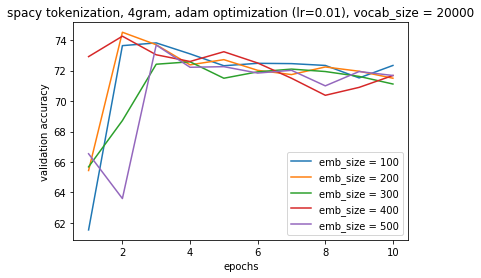

In [171]:
emb_dim_list = [100, 200, 300, 400, 500]
for i in range(len(val_curve_adam_4gram_embedsize)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_4gram_embedsize[i], label = 'emb_size = %s' %emb_dim_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, 4gram, adam optimization (lr=0.01), vocab_size = %s' %max_vocab_size)

In [172]:
C = pd.Index(["100", "200", "300", "400", "500"], name="embed size")
I = pd.Index(["1-gram", "2-gram", "3-gram", "4-gram"], name="ngram")
df = pd.DataFrame(data=np.random.rand(4,5), index=I, columns=C)

df.iloc[0] = val_acc_adam_embedsize
df.iloc[1] = val_acc_adam_bigram_embedsize
df.iloc[2] = val_acc_adam_trigram_embedsize
df.iloc[3] = val_acc_adam_4gram_embedsize

df

embed size,100,200,300,400,500
ngram,,,,,
1-gram,83.02,82.80,82.22,82.48,82.76
2-gram,82.80,82.52,82.82,82.20,82.42
3-gram,78.08,78.00,78.44,77.90,77.90
4-gram,72.02,71.50,71.60,71.34,71.82
